In [1]:
# load and the test weekly fpl scrape
season="2019-20"
gw=13
model_type="rf"

In [2]:
import os
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
%matplotlib inline
import pickle

In [3]:
os.chdir(os.path.join(os.getcwd(), "..", "..", "data"));

In [4]:
random_state = np.random.seed(24)

In [5]:
X_train = pd.read_csv("x-train.csv");
X_test = pd.read_csv("x-test.csv");

In [6]:
y_train = pd.read_csv("y-train.csv");
y_test = pd.read_csv("y-test.csv");

In [7]:
# parameters = {
#     'n_estimators': [400, 800, 1600], 
#     'max_depth': [16],
#     'min_samples_split': [8],
#     'min_samples_leaf': [64],
#     'max_leaf_nodes': [2, 4, 8, 16],
#     'oob_score': [True, False]
# }
parameters = {
    'n_estimators': [100], 
    'max_depth': [16],
    'min_samples_split': [8],
    'min_samples_leaf': [64],
}
# {'max_depth': 16,
#  'min_samples_leaf': 64,
#  'min_samples_split': 8,
#  'n_estimators': 100}

In [8]:
regressor = RandomForestRegressor(random_state=random_state, n_jobs=-1)

In [9]:
clf = GridSearchCV(regressor, parameters, scoring='r2', cv=5, n_jobs=-1, verbose=5)

In [10]:
clf.fit(X_train, y_train)  

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   24.8s remaining:   37.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.9s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100], 'max_depth': [16], 'min_samples_split': [8], 'min_samples_leaf': [64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=5)

In [11]:
clf.best_params_

{'max_depth': 16,
 'min_samples_leaf': 64,
 'min_samples_split': 8,
 'n_estimators': 100}

In [12]:
clf.best_score_

0.2688567012992024

In [13]:
regressor = clf.best_estimator_

In [14]:
y_pred = regressor.predict(X_test)

In [15]:
def getInRange(actual, predicted, lower_bound=0, upper_bound=1):
    return ((actual - predicted) >= lower_bound) and ((actual - predicted) <= upper_bound)

In [16]:
pred_df = pd.DataFrame({'Actual': np.array(y_test).flatten(), 'Predicted': y_pred.flatten()})

In [17]:
pred_df["in_range"] = pred_df.apply(lambda row: getInRange(row["Actual"], row["Predicted"]), axis=1)

In [18]:
print("In range: {0:.2f}".format(pred_df[pred_df["in_range"] == True].shape[0]/pred_df.shape[0]))

In range: 0.08


In [19]:
pred_df.head(25)

,Actual,Predicted,in_range
0,0,0.104909,False
1,0,0.057737,False
2,3,3.695483,False
3,2,3.147913,False
4,0,0.122308,False
5,0,0.085055,False
6,1,2.159354,False
7,2,3.172369,False
8,0,2.088316,False
9,2,3.891940,False


In [20]:
test_df = pred_df.head(25)

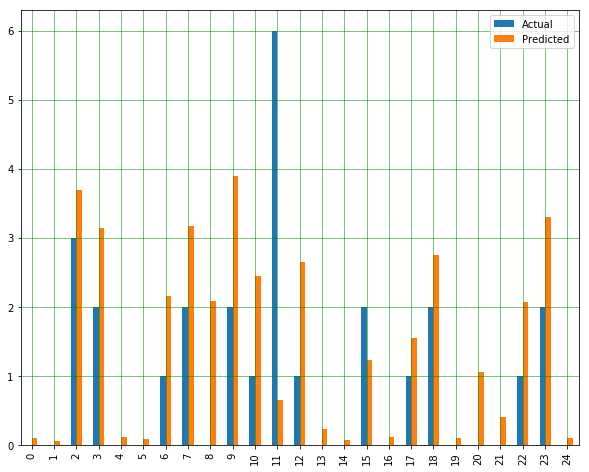

In [21]:
test_df.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [22]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('R2 score:', metrics.r2_score(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1.2433628580779048
R2 score: 0.26710811659394185
Mean Squared Error: 4.63143119637436
Root Mean Squared Error: 2.1520760201197264


In [23]:
filename = '{}-model.pkl'.format(model_type)

In [24]:
gw_dir = os.path.join(os.getcwd(), "..", "model", season, str(gw))

In [25]:
if not os.path.exists(gw_dir):
    os.makedirs(gw_dir)

In [26]:
os.chdir(gw_dir)

In [27]:
with open(filename, 'wb') as file:
    pickle.dump(regressor, file)